In [4]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor  
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import LinearSVR
from sklearn import svm
import numpy as np

In [5]:
def rmsle(y_pred, y_true) :
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

### Import danych surowych
#### Podstawowa baza danych

In [6]:
data = pd.read_csv("bikes_train.csv")

data["datetime"] = pd.to_datetime(data["datetime"])
data["dayofweek"] = data["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
data["year"] = data["datetime"].dt.year
data["month"] = data["datetime"].dt.month
data["day"] = data["datetime"].dt.day
data["hour"] = data["datetime"].dt.hour
del data["datetime"] # usunięcie rozbitej kolumny

data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,2011,1,1,4


#### Wydzielenie zmiennych zależnych i features

In [7]:
features = ["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","dayofweek","year","month","day","hour"]
X = data[features]

y_casual = data["casual"]
y_registered = data["registered"]

#### Podział zbioru uczącego na wewnętrzny zbiór uczący i testowy

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_casual+y_registered, test_size=0.2, random_state=42)

### Utworzenie modeli z użyciem wewnętrznego zbioru danych
#### Liniowy SVM

In [6]:
#Cvals = list(map(lambda x: 2**x,range(-8,11)))
#Evals = list(map(lambda x: 2**x,range(-12,5)))
Cvals = list(map(lambda x: 2**x,range(-1,3)))
Evals = list(map(lambda x: 2**x,range(-5,0)))
SVRparameters = {"C":Cvals, "loss":["epsilon_insensitive","squared_epsilon_insensitive" ], "epsilon":Evals}
SVRegressor = GridSearchCV(estimator = LinearSVR(), param_grid = SVRparameters, return_train_score=True, n_jobs=4)
SVRegressor.fit(X = X_train, y = y_train)
SVRegressor.best_estimator_

LinearSVR(C=4, dual=True, epsilon=0.0625, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [7]:
y_pred = SVRegressor.predict(X_test)
rmsle(y_pred, y_test)

C:\Users\miser\AppData\Local\conda\conda\envs\isa\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


1.0614717266748996

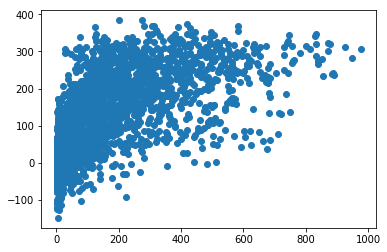

In [8]:
plt.scatter(y_test, y_pred)

#### Decision tree

In [6]:
DTparameters = {'max_depth': range(1, 11),
              'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21)}
DTRegressor = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = DTparameters, n_jobs=4)
DTRegressor.fit(X = X_train, y=y_train)
DTRegressor.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [10]:
y_pred = DTRegressor.predict(X_test)
rmsle(y_pred, y_test)

0.3856016648118477

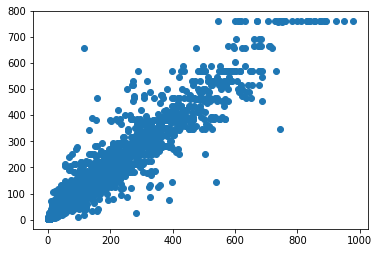

In [11]:
plt.scatter(y_test, y_pred)

#### Random forest

In [9]:
RFparameters = {"n_estimators":[100],  "bootstrap":[True, False], "criterion":["mse"]} 
RFRegressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=RFparameters, return_train_score=True, n_jobs=4)
RFRegressor.fit(X = X_train, y = y_train)
RFRegressor.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
y_pred = RFRegressor.predict(X_test)
rmsle(y_pred, y_test)

0.32954504942964047

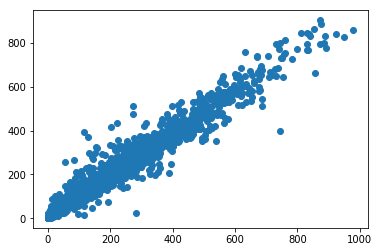

In [12]:
plt.scatter(y_test, y_pred)

In [19]:
pd.DataFrame(y_pred).to_csv(path_or_buf="y_pred.csv")
pd.DataFrame(X_test).to_csv(path_or_buf="X_test.csv")